## **FlexiBench Cardiotocography MLP Quantization**
### Author: Shvetank Prakash
### Date: Jan 2025
#### Dataset: [UCI Cardiotocography](https://archive.ics.uci.edu/dataset/193/cardiotocography)
#### Helpful links:

[Co-Design of Approximate Multilayer Perceptron for Ultra-Resource Constrained Printed Circuits](https://arxiv.org/abs/2302.14576) (Paper Results Reproduced)

[Gemmlowp Paper](https://arxiv.org/pdf/1712.05877)

[Gemmlowp Implementation](https://github.com/google/gemmlowp/tree/master)


# Basic Imports and Global Defs

In [1]:
!pip install tensorflow-model-optimization==0.8.0
!pip install ucimlrepo==0.0.7

In [2]:
import os
import csv
import math
import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_model_optimization as tfmot
from sklearn.model_selection import train_test_split


# Setting environment variables
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
# Model Parameters
INPUT_SIZE = 21
HIDDEN_SIZE = 3
OUTPUT_SIZE = 3

# Training Parameters
EPOCHS = 200
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_TEST = 64
LEARNING_RATE = 0.001

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# **Read and Preprocess Dataset**

In [4]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset
cardiotocography = fetch_ucirepo(id=193)

# Data (as pandas dataframes)
X = cardiotocography.data.original.iloc[:, :21].astype('float32')
X = (X - X.min()) / (X.max() - X.min())  # normalize all columns of X between 0 and 1
y = cardiotocography.data.original['NSP']  # fetal state class code (N=normal; S=suspect; P=pathologic)
y = y.values - 1  # adjust class labels from [1,2,3] --> [0,1,2]

# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)  # Adjust test_size and random_state as needed

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), seed=SEED).batch(BATCH_SIZE_TRAIN)
test_dataset = test_dataset.batch(BATCH_SIZE_TEST)

In [5]:
def load_csv_data(csv_file, keep_quant=False):
    df = pd.read_csv(csv_file)
    inputs = df.iloc[:, :-1].values
    targets = df.iloc[:, -1].values - 1
    if not keep_quant:
        inputs, targets
        inputs = inputs.astype('float32') / 255.0
    dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))

    return dataset

# Load in dataset from csv (Old implementation replaced with getting data from python package)
# train_dataset = load_csv_data('quantized_training_data.csv')
# print(train_dataset)
# train_dataset = train_dataset.shuffle(buffer_size=len(list(train_dataset)), seed=SEED)
# train_dataset = train_dataset.batch(BATCH_SIZE_TRAIN)

# test_dataset = load_csv_data('quantized_test_data.csv')
# print(test_dataset)
# test_dataset = test_dataset.batch(BATCH_SIZE_TEST)

In [6]:
# Print one sample from train and test dataset each
print("Train Dataset Sample:")
for x, y in train_dataset.take(1):
    print(f"Inputs: {x}")
    print(f"Label:  {y}")

print("Test Dataset Sample:")
for x, y in test_dataset.take(1):
    print(f"Inputs: {x}")
    print(f"Label:  {y}")

Train Dataset Sample:
Inputs: [[0.7777778  0.         0.         ... 0.73394495 0.00371747 1.        ]
 [0.6851852  0.         0.         ... 0.6238532  0.00371747 1.        ]
 [0.5        0.         0.002079   ... 0.5504587  0.         0.5       ]
 ...
 [0.6666667  0.68421054 0.         ... 0.6880734  0.01858736 0.5       ]
 [0.6481481  0.05263158 0.         ... 0.6605505  0.00371747 1.        ]
 [0.25925925 0.         0.         ... 0.22018349 0.23791821 0.        ]]
Label:  [1 1 0 0 2 0 0 0 0 0 2 2 1 0 0 0 2 0 0 0 0 0 2 0 1 0 2 0 0 0 0 0 2 0 0 0 0
 2 0 0 2 1 0 0 1 1 1 0 1 0 0 2 0 0 2 2 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 2 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 2 0 0
 0 1 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 2 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 2 0 0 0 2 0 1 2 0 0 2 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 2 1 2 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 2

# **Create Model**

In [7]:
def create_mlp(input_size, hidden_size, output_size):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(input_size,)),
        layers.Dense(hidden_size, activation='relu'),
        layers.Dense(output_size)
    ])
    return model

model = create_mlp(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78 (312.00 B)

 Trainable params: 78 (312.00 B)

 Non-trainable params: 0 (0.00 B)

# **Train from Scratch in FP32**

In [8]:
# Initial non-quant training
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset
    )

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7814 - loss: 0.9062 - val_accuracy: 0.7817 - val_loss: 0.8887
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7809 - loss: 0.8840 - val_accuracy: 0.7817 - val_loss: 0.8676
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7745 - loss: 0.8682 - val_accuracy: 0.7817 - val_loss: 0.8465
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7789 - loss: 0.8467 - val_accuracy: 0.7817 - val_loss: 0.8258
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7630 - loss: 0.8353 - val_accuracy: 0.7817 - val_loss: 0.8058
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7834 - loss: 0.7965 - val_accuracy: 0.7817 - val_loss: 0.7862
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7881 - loss: 0.7735 - val_accuracy: 0.7817 - val_loss: 0.7678
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7802 - loss: 0.7658 - val_accuracy: 0.7817 - val_loss: 0.75

# **Vizualize Training History**

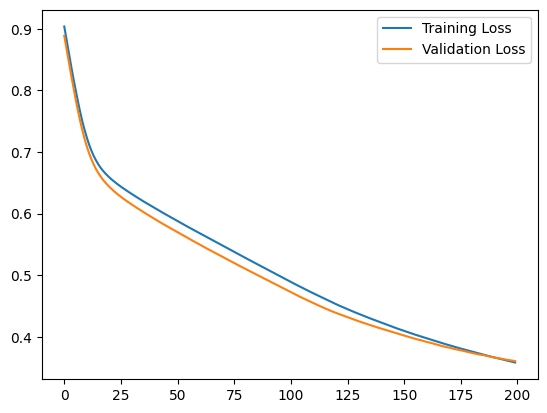

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# **Test Set Classification Accuracy of FP32 Model**

In [10]:
# Evaluate the FP32 model
results = model.evaluate(test_dataset)

# Print the results
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

# Goal: Target Accuracy >= 0.85

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8749 - loss: 0.3740
Test Loss: 0.3603757619857788, Test Accuracy: 0.8732394576072693


# **Convert to TFLite Model**

In [11]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Print tensor details
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
for tensor in interpreter.get_tensor_details():
    print(tensor['name'], tensor['dtype'])
    try:
        # Attempt to get tensor data
        tensor_data = interpreter.get_tensor(tensor['index'])
        print(tensor_data)
    except ValueError:
        # Skip tensors with null data
        print(f"Skipping tensor '{tensor['name']}' as it has null data.")

Saved artifact at '/tmp/tmp4d1ngffz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132167652528336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132167652526992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132167652528144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132167652526800: TensorSpec(shape=(), dtype=tf.resource, name=None)
serving_default_keras_tensor:0 <class 'numpy.float32'>
[[1.5602182e+11 4.3122158e-41 1.5602182e+11 4.3122158e-41 1.0361846e-31
  0.0000000e+00 1.5601500e+11 4.3122158e-41 0.0000000e+00 0.0000000e+00
  4.6242849e-44 0.0000000e+00 1.0342921e-31 0.0000000e+00 1.5601500e+11
  4.3122158e-41 1.2331426e-42 0.0000000e+00 1.7936620e-43 0.0000000e+00
  1.0213057e-31]]
arith.constant <class 'numpy.float32'>
[[ 1.7178907   0.5369177   0.406291  ]
 [-1.0

# **Convert to Quantized Model**

In [12]:
# Provide a representative dataset to guide the quantization process
def representative_dataset_gen():
    for data, _ in test_dataset.unbatch().batch(1).take(100):
        yield [data]

# Convert the model to int8 format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.experimental_new_quantizer = False  # Optional: Use the default quantizer
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

# Save the model
with open('model_quantized.tflite', 'wb') as f:
  f.write(tflite_quant_model)

# Print tensor details
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

for tensor in interpreter.get_tensor_details():
    print(tensor['name'], tensor['dtype'])
    try:
        # Attempt to get tensor data
        tensor_data = interpreter.get_tensor(tensor['index'])
        print(tensor_data)
    except ValueError:
        # Skip tensors with null data
        print(f"Skipping tensor '{tensor['name']}' as it has null data.")

Saved artifact at '/tmp/tmpv__t4ufv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132167652528336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132167652526992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132167652528144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132167652526800: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


serving_default_keras_tensor:0_int8 <class 'numpy.int8'>
[[ 16  79  17  82  53 120   0   0  96  88  14  12   0   0   0   0  48  36
  -58   8   0]]
arith.constant <class 'numpy.int8'>
[[ 127   40   30]
 [ -81   91    4]
 [  15 -119  -63]]
sequential_1/dense_1_2/Add/ReadVariableOp <class 'numpy.int32'>
[ -906 -3877  3253]
sequential_1/dense_1/Add/ReadVariableOp <class 'numpy.int32'>
[9064 1891    0]
sequential_1/dense_1/MatMul <class 'numpy.int8'>
[[ -33  127  -26   72   31  -42 -112  -49   79  -84   34   18    8   -7
   -18    1  -16   12   29  -70   32]
 [  27   21  -35    4  -46  -70 -116  -17  -27  -82   86    5   -6    8
    31   12   48   -1   64  -76   28]
 [ -12   13    2   -4    0  -26  -39  -20   -3  -25  -32  -32   15    5
    38  -20   10  -32   -6  -38  -10]]
sequential_1/dense_1/MatMul;sequential_1/dense_1/Relu;sequential_1/dense_1/Add <class 'numpy.int8'>
Skipping tensor 'sequential_1/dense_1/MatMul;sequential_1/dense_1/Relu;sequential_1/dense_1/Add' as it has null data.
S

# **Test Set Classification Accuracy of 8-bit Model**

---



In [13]:
# Test accuracy of quantized model
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

correct = 0.0
total = 0.0

# Define the transformation function
def convert_to_int8(X, y):
    X = tf.cast((X * 255) - 128, tf.int8)  # Multiply by 255 and subtract 128 cast to int8
    return X, y

# Apply the transformation to the dataset
test_dataset_quantized_inputs = test_dataset.map(convert_to_int8).unbatch()

# Example: Inspect the first batch
for X_batch, y_batch in test_dataset_quantized_inputs.take(1):
    print(X_batch.numpy(), y_batch.numpy())
for input, label in test_dataset_quantized_inputs.batch(1):
    interpreter.set_tensor(input_details[0]['index'], input.numpy().astype('int8'))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    total += 1
    if output.argmax() == label.numpy()[0]:
        correct += 1

print(f"Quantized Model Test Set Accuracy: {correct / total}")

[   0 -101 -122  -77  -94 -128 -128  -12  -94 -128  -50  -32  -22  -35
  -57 -128   30   17   14 -119    0] 0
Quantized Model Test Set Accuracy: 0.8732394366197183


In [14]:
# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

# Extract tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
all_tensor_details = interpreter.get_tensor_details()

# Extract weights, biases, scales, and zero points from allocated tensors
quantized_params = {}
for tensor in all_tensor_details:
    # Check if the tensor has quantization parameters and valid data
    try:
        # Attempt to get tensor data
        tensor_data = interpreter.get_tensor(tensor['index'])

        if 'quantization_parameters' in tensor and tensor['quantization_parameters']['scales'].size > 0:
            quantized_params[tensor['name']] = {
                'values': tensor_data,
                'scale': tensor['quantization_parameters']['scales'],
                'zero_point': tensor['quantization_parameters']['zero_points']
            }
    except ValueError:
        # Skip tensors with null data
        if 'quantization_parameters' in tensor and tensor['quantization_parameters']['scales'].size > 0:
            quantized_params[tensor['name']] = {
                'scale': tensor['quantization_parameters']['scales'],
                'zero_point': tensor['quantization_parameters']['zero_points']
            }
        print(f"Skipping tensor '{tensor['name']}' as it has null data.")

print("Quantized parameters extracted.")

Skipping tensor 'sequential_1/dense_1/MatMul;sequential_1/dense_1/Relu;sequential_1/dense_1/Add' as it has null data.
Quantized parameters extracted.


# **Print Names, Weights, Scales, and Zero Points of Quantized Model Tensors'**

In [15]:
for name, params in quantized_params.items():
    print(f"{name} - Scale: {params['scale']}, Zero Point: {params['zero_point']}")
    if 'values' in params:
      print(params['values'])

serving_default_keras_tensor:0_int8 - Scale: [0.00392157], Zero Point: [-128]
[[112  80 117  11   0   0   0   0 -16 -35 -12  11   0   0   0   0   0   0
    0   0   0]]
arith.constant - Scale: [0.0135267], Zero Point: [0]
[[ 127   40   30]
 [ -81   91    4]
 [  15 -119  -63]]
sequential_1/dense_1_2/Add/ReadVariableOp - Scale: [0.0001275], Zero Point: [0]
[ -906 -3877  3253]
sequential_1/dense_1/Add/ReadVariableOp - Scale: [4.7085505e-05], Zero Point: [0]
[9064 1891    0]
sequential_1/dense_1/MatMul - Scale: [0.0120068], Zero Point: [0]
[[ -33  127  -26   72   31  -42 -112  -49   79  -84   34   18    8   -7
   -18    1  -16   12   29  -70   32]
 [  27   21  -35    4  -46  -70 -116  -17  -27  -82   86    5   -6    8
    31   12   48   -1   64  -76   28]
 [ -12   13    2   -4    0  -26  -39  -20   -3  -25  -32  -32   15    5
    38  -20   10  -32   -6  -38  -10]]
sequential_1/dense_1/MatMul;sequential_1/dense_1/Relu;sequential_1/dense_1/Add - Scale: [0.00942592], Zero Point: [-128]
Statefu

# **Map TFLite Provided Names to Intuitive Ones**
The TFLite Layer names after quantization are not very intuitive.
Use the names above + the [Netron](https://netron.app/) application to update dictionary below so that it is very clear which layer is which. *You may need to update the names if any changes are made to the notebook.*

In [16]:
# Layer name map
layer_name_map = {
    "input_layer": "serving_default_keras_tensor:0_int8",
    "layer_one_weights": "sequential_1/dense_1/MatMul",
    "layer_one_bias": "sequential_1/dense_1/Add/ReadVariableOp",
    "layer_one_output_activations": "sequential_1/dense_1/MatMul;sequential_1/dense_1/Relu;sequential_1/dense_1/Add",
    "layer_two_weights": "arith.constant",
    "layer_two_bias": "sequential_1/dense_1_2/Add/ReadVariableOp",
    "output_layer": "StatefulPartitionedCall_1:0_int8"
}

In [17]:
input_layer_scale = quantized_params[layer_name_map["input_layer"]]["scale"]
input_layer_zero_point = quantized_params[layer_name_map["input_layer"]]["zero_point"]

layer_one_weights = quantized_params[layer_name_map["layer_one_weights"]]["values"]
layer_one_weights_scale = quantized_params[layer_name_map["layer_one_weights"]]["scale"]
layer_one_weights_zero_point = quantized_params[layer_name_map["layer_one_weights"]]["zero_point"]
layer_one_bias = quantized_params[layer_name_map["layer_one_bias"]]["values"]

layer_one_output_activations_scale = quantized_params[layer_name_map["layer_one_output_activations"]]["scale"]
layer_one_output_activations_zero_point = quantized_params[layer_name_map["layer_one_output_activations"]]["zero_point"]

layer_two_weights = quantized_params[layer_name_map["layer_two_weights"]]["values"]
layer_two_weights_scale = quantized_params[layer_name_map["layer_two_weights"]]["scale"]
layer_two_weights_zero_point = quantized_params[layer_name_map["layer_two_weights"]]["zero_point"]
layer_two_bias = quantized_params[layer_name_map["layer_two_bias"]]["values"]

output_layer_scale = quantized_params[layer_name_map["output_layer"]]["scale"]
output_layer_zero_point = quantized_params[layer_name_map["output_layer"]]["zero_point"]

In [18]:
def calculate_fixed_point_multiplier(input_scale, weight_scale, output_scale):
    # Calculate M0 and N from M = 2^-N M0 = (S1 * S2 / S3)
    multiplier = input_scale * weight_scale / output_scale
    shift = 0
    while multiplier < 0.5:
        multiplier *= 2
        shift += 1
    quantized_multiplier = multiplier * math.pow(2, 31)
    return quantized_multiplier, shift

In [19]:
# First layer requantization params
layer_one_multiplier, layer_one_shift = calculate_fixed_point_multiplier(input_layer_scale, layer_one_weights_scale, layer_one_output_activations_scale)

# Second layer requantization params
layer_two_multiplier, layer_two_shift = calculate_fixed_point_multiplier(layer_one_output_activations_scale, layer_two_weights_scale, output_layer_scale)

subscript_printing = str.maketrans("123456789", "₁₂₃₄₅₆₇₈₉")
print("Layer 1 Requantization Params:")
print("M01: ".translate(subscript_printing) + f"{layer_one_multiplier[0]:.2f}")
print("N1: ".translate(subscript_printing)  + f"{layer_one_shift}")

print("Layer 2 Requantization Params:")
print("M02: ".translate(subscript_printing) + f"{layer_two_multiplier[0]:.2f}")
print("N2: ".translate(subscript_printing)  + f"{layer_two_shift}")

Layer 1 Requantization Params:
M0₁: 1373103872.00
N₁: 7
Layer 2 Requantization Params:
M0₂: 1142335232.00
N₂: 7


# **Emulate 8-bit Integer Inference with Numpy**

In [20]:
# Create copy of test dataset
TEST_SET_SIZE = 426
test_dataset_copy = (iter(test_dataset_quantized_inputs.take(TEST_SET_SIZE)))

In [21]:
def run_tflite_golden_inference(tflite_model, inputs, debug=False):
    #
    # Golden Reference Implementation of TFLite Inference running on a single sample
    #

    # Add batch dim to single data sample
    inputs = np.expand_dims(inputs, 0)

    # Load TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_content=tflite_model, experimental_preserve_all_tensors=True)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Load input tensor
    interpreter.set_tensor(input_details[0]['index'], inputs)

    # Run the model
    interpreter.invoke()

    # Print each layer's output if needed for verification
    if debug:
      print({
          t['name']: interpreter.get_tensor(t['index'])
          for t in interpreter.get_tensor_details()
      })

    return interpreter.get_tensor(output_details[0]['index'])

In [22]:
def run_numpy_inference(input):
  #
  # Numpy Reference Implementation of TFLite Inference running on a single sample
  #

  # (Inputs * Layer 1 Weights) + Bias followed by ReLU
  x = np.matmul((input.numpy().astype(np.int32) - input_layer_zero_point.astype(np.int32)),(layer_one_weights.T.astype(np.int32) - layer_one_weights_zero_point.astype(np.int32)))
  x = x + layer_one_bias
  x = np.maximum(x, 0)

  # Requantization pipeline
  x = x * layer_one_multiplier
  x = np.round((x / np.power(2,31))).astype(np.int32)
  x = np.round((x / np.power(2, layer_one_shift))).astype(np.int32)
  x = x + layer_one_output_activations_zero_point.astype(np.int32)
  x = np.clip(x, -128, 127)

  # (Layer 1 Activations * Layer 2 Weights) + Bias
  x = np.matmul((x.astype(np.int32) - layer_one_output_activations_zero_point.astype(np.int32)), (layer_two_weights.T.astype(np.int32) - layer_two_weights_zero_point.astype(np.int32)))
  x = x + layer_two_bias

  # Requantization pipeline
  x = x * layer_two_multiplier
  x = np.round((x / np.power(2,31))).astype(np.int32)
  x = np.round((x / np.power(2, layer_two_shift))).astype(np.int32)
  x = x + output_layer_zero_point.astype(np.int32)
  x = np.clip(x, -128, 127)

  return x


In [23]:
tflite_correct = 0.0
numpy_correct = 0.0

for inputs, targets in test_dataset_copy:
  tflite_output = run_tflite_golden_inference(tflite_quant_model, inputs)
  numpy_output = run_numpy_inference(inputs)

  # Make sure that raw values of output tensors match exactly to validate numpy reference implementation
  if np.array_equal(tflite_output.flatten()[0], numpy_output.flatten()):
    print(tflite_output)
    print(numpy_output)
    print("ERROR: TFlite Golden Output Tensor does not match Numpy Implementation Output Tensor")

  # Update num correct
  if tflite_output.argmax() == targets.numpy():
    tflite_correct += 1
  if numpy_output.argmax() == targets.numpy():
    numpy_correct += 1



# Make sure accuracy is exactly the same to validate numpy implementation
print(f"TF Lite Accuracy: {tflite_correct / TEST_SET_SIZE}")
print(f"Numpy Accuracy: {numpy_correct / TEST_SET_SIZE}")
print("Numpy Implementation matches TFLite Golden Implementation!" if tflite_correct / TEST_SET_SIZE == numpy_correct / TEST_SET_SIZE else "Numpy Implementation does NOT match TFLite Golden Implementation...")

TF Lite Accuracy: 0.8732394366197183
Numpy Accuracy: 0.8732394366197183
Numpy Implementation matches TFLite Golden Implementation!


# **Write Test Set Data to CSV for C Implementation in Flexibench Repository**

In [24]:
def dump_test_data_to_csv(dataset, headers, filename):
  with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    tflite_correct = 0.0
    for inputs, targets in dataset:
      # Write the original TFLite model prediction along with inputs and ground truth label to the CSV for reference
      tflite_model_output = run_tflite_golden_inference(tflite_quant_model, inputs)
      tflite_model_prediction = tflite_model_output.argmax()  # get classs label and convert to array
      if tflite_model_prediction == targets.numpy():
        tflite_correct += 1
      writer = csv.writer(csvfile)
      writer.writerow(np.append(inputs.numpy(), [tflite_model_prediction, targets.numpy()]))
    print(f"TF Lite Accuracy: {tflite_correct / TEST_SET_SIZE}")
    print("CSV saved.")

column_names = cardiotocography.data.original.columns.tolist()[:-2] + ['TFLite_Model_Prediction'] + ['NSP_Golden_Label']
dataset_copy_for_csv = iter(test_dataset_quantized_inputs.take(TEST_SET_SIZE))
dump_test_data_to_csv(dataset_copy_for_csv, column_names, 'samples.csv')

TF Lite Accuracy: 0.8732394366197183
CSV saved.
